# Loading cell objects lists and original image, drawing cells with measurments

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import skimage
from skimage.draw import polygon_perimeter
import pickle
import tifffile
import pandas as pd
import skimage.io
import skimage.color
import seaborn as sns
from cell_obj import CellObj, add_measured_value, save_objects_as_pickle

In [3]:
image_path = 'test_2.jpg'
cell_list_path = 'cell_list_for_labeling.pickle'

In [4]:
def image_loader(path):
    '''loads an image'''
    image = skimage.io.imread(path)
    return image, hash(tuple(image.tobytes()))

image, image_hash = image_loader(image_path)

In [5]:
cell_list = []
#Opening file and unpuckling its content
with open(cell_list_path , 'rb') as pickled_file:
    cell_list = pickle.load(pickled_file)

In [6]:
def annotation_text_maker(annotation_text, value_name, cell_obj, scale_metric=""):
    '''prepares a string to annotate a cell'''
    new_annotation = value_name + " : " + str(cell_obj.measured_values[value_name]) + scale_metric
    return (annotation_text + "\n" + new_annotation)

In [7]:
def labeling_image(image,image_hash, cell_obj_list, values_to_write=None):
    '''from https://muthu.co/draw-bounding-box-around-contours-skimage/
    Draws a boudning box and contour around cells, label them according to infered class if 
    present, writes additional information  '''
    assert image_hash == cell_obj_list[0].original_image_hash
    #rewrite so it uses cell_obj_list
    contours = [cell.contour for cell in cell_obj_list]
    boxed_img = np.copy(image) 
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)
        
    if contours:
        for n, contour in enumerate(contours):
            ax.plot(contours[n][:, 1], contours[n][:, 0], linewidth=2)

    if values_to_write:
        for cell_obj in cell_obj_list:
            color_list = [(255,255,255), (0,255,0), (255,0,0)]
            plt.scatter(cell_obj.measured_values['center_of_mass_x'], 
                        cell_obj.measured_values['center_of_mass_y'], s=200, 
                        c='white', marker='x')
            annotation_text = ''
            for value_name in values_to_write:
                annotation_text = annotation_text_maker(annotation_text, value_name, cell_obj)
            ax.add_patch(Rectangle((cell_obj.return_center_of_box()[0]+image.shape[0]*0.05+3, cell_obj.return_center_of_box()[1]),
                                   image.shape[0]*0.15, image.shape[0]*0.05, color='white', alpha=0.6))
            plt.text(cell_obj.return_center_of_box()[0]+image.shape[0]*0.05+5, cell_obj.return_center_of_box()[1]+image.shape[1]*0.03, 
                        str(annotation_text), c=(0,0,0), fontsize=10)
            # drawing multi colored boxes
            r = [cell_obj.box_coord[0],cell_obj.box_coord[1],cell_obj.box_coord[1],cell_obj.box_coord[0], cell_obj.box_coord[0]]
            c = [cell_obj.box_coord[3],cell_obj.box_coord[3],cell_obj.box_coord[2],cell_obj.box_coord[2], cell_obj.box_coord[3]]
            rr, cc = polygon_perimeter(r, c, image.shape)
            boxed_img[rr, cc] = color_list[cell_obj.measured_values['KMeans_label']] 
    ax.imshow(boxed_img, interpolation='nearest', cmap=plt.cm.gray)
 
    plt.show()

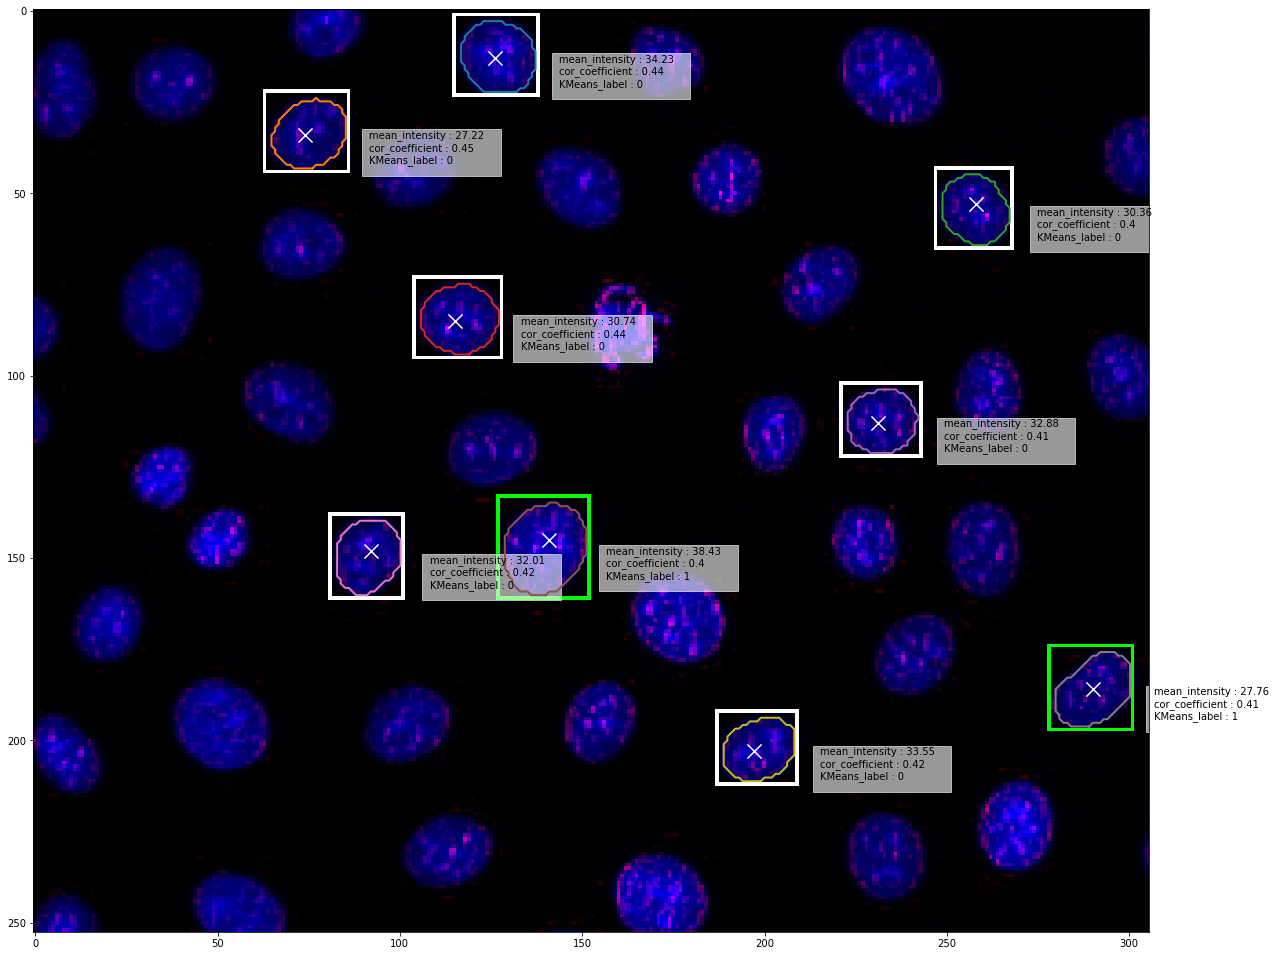

In [11]:
values_to_show = ['mean_intensity', 'cor_coefficient', 'KMeans_label']
labeling_image(image,image_hash, cell_list[::4], values_to_show)

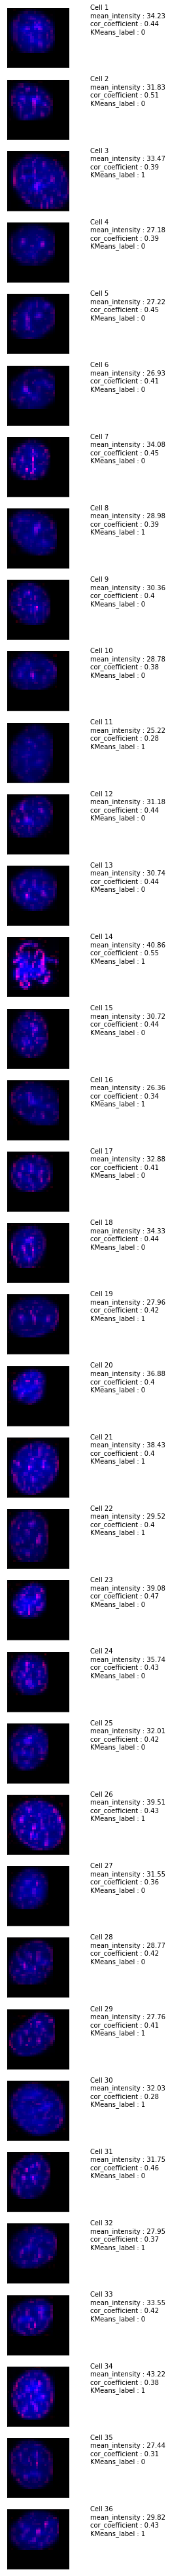

In [9]:
def make_montage(image_list,values_to_write,path_to_save, n_channels):
    '''makes a montage of all cells with morphometric information'''
    #finding the largest cell image
    largest_box = [0, 0]
    for cell in cell_list:
        x_dim = cell.box_coord[1] - cell.box_coord[0]
        y_dim = cell.box_coord[3] - cell.box_coord[2]
        if x_dim > largest_box[0]:
            largest_box[0] = x_dim
        if y_dim > largest_box[1]:
            largest_box[1] = y_dim     
    n_rows = len(image_list)
    n_cols = 1

    fig, axs = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(6, len(image_list)*2)

    for i in range(len(image_list)):
        # enlarging an image to the largest size
        small_image = cell_list[i].images_dict['cut_image']
        enlarged_image = np.zeros((largest_box[0],largest_box[1]))
        enlarged_image.fill(0)
        enlarged_image  = np.stack((enlarged_image,)*n_channels, axis=-1).astype('int16')
        x = 0
        y = 0
        enlarged_image[x:x+small_image.shape[0], y:y+small_image.shape[1]] = small_image
        # writing text
        annotation_text = f'Cell {str(i+1)}'
        for value_name in values_to_write:
                annotation_text = annotation_text_maker(annotation_text, value_name, cell_list[i])
        axs[i].text(largest_box[1]+10,12,annotation_text)

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(enlarged_image, interpolation='nearest', cmap=plt.cm.gray)
        
    if path_to_save:
        plt.savefig(fname=path_to_save, bbox_inches = 'tight')
    plt.show()

path_to_save = (r'figures/'+str(image_hash))
make_montage(cell_list,values_to_show,path_to_save, 3)